# Monocular Single Human Pose Estimation

In [1]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 191 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (191/191), 70.07 KiB | 969.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.
Note: checking out '18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 18f1d0f Update README.md


In [2]:
! pip install onnx onnxruntime

     |████████████████████████████████| 12.7 MB 2.8 MB/s 
     |████████████████████████████████| 4.8 MB 40.1 MB/s 


In [4]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [5]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T

import cv2

import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
import models
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name

We are going to use MPII - ResNet50 Model trained on `256x256` sized images
model_file: https://drive.google.com/file/d/1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc/view?usp=sharing

In [7]:
! gdown https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc

Downloading...
From: https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc
To: /content/pose_resnet_50_256x256.pth.tar
100% 136M/136M [00:02<00:00, 62.7MB/s]


The corresponding config file is taken from experiments folder

In [8]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

In [9]:
update_config(CONFIG_FILE)
config.GPUS = '' # we are running on CPU

Load the model

In [10]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Pose Lady

In [11]:
! wget https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg -O pose.jpg

--2021-11-29 09:33:14--  https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.200.152.239, 2606:4700::6812:fb0, 2606:4700::6812:eb0
Connecting to i.pinimg.com (i.pinimg.com)|23.200.152.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12170 (12K) [image/jpeg]
Saving to: ‘pose.jpg’

pose.jpg            100%[===================>]  11.88K  --.-KB/s    in 0s      

2021-11-29 09:33:14 (112 MB/s) - ‘pose.jpg’ saved [12170/12170]



Pose Man

In [12]:
! wget https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png -O pose.png

--2021-11-29 09:33:19--  https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving habrastorage.org (habrastorage.org)... 82.192.95.170
Connecting to habrastorage.org (habrastorage.org)|82.192.95.170|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png [following]
--2021-11-29 09:33:20--  https://hsto.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving hsto.org (hsto.org)... 104.26.12.161, 104.26.13.161, 172.67.71.175, ...
Connecting to hsto.org (hsto.org)|104.26.12.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211894 (207K) [image/png]
Saving to: ‘pose.png’

pose.png            100%[===================>] 206.93K   772KB/s    in 0.3s    

2021-11-29 09:33:22 (772 KB/s) - ‘pose.png’ saved [211894/211894]



And this is me

In [13]:
! wget https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg?raw=true -O satyajit-pose.jpg

--2021-11-29 09:33:24--  https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/raw/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg [following]
--2021-11-29 09:33:25--  https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/raw/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/master/05-HumanPoseEstimation-ONNX/satyajit-pose-small.jpg [following]
--2021-11-29 09:33:25--  https://raw.githubusercontent.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/master

In [14]:
IMAGE_FILE = 'satyajit-pose.jpg'

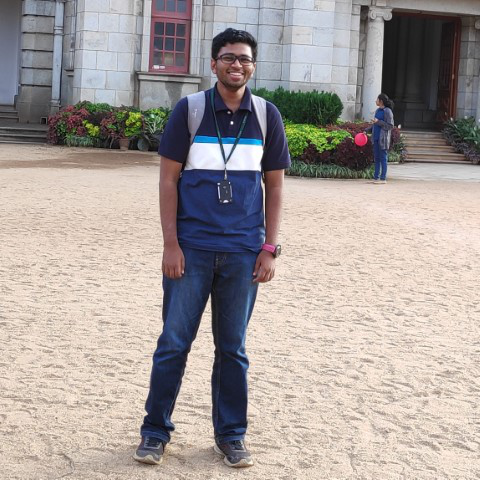

In [15]:
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
image

In [22]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

In [26]:
import cv2
import onnx
import torch
from albumentations import (Compose,Resize,)
from albumentations.augmentations.transforms import Normalize
from albumentations.pytorch.transforms import ToTensor
from torchvision import models

def preprocess_image(img_path):
    # transformations for the input data
    transforms = Compose([
        Resize(256, 256, interpolation=cv2.INTER_NEAREST),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensor(),
    ])

    # read input image
    input_img = cv2.imread(img_path)
    # do transformations
    input_data = transforms(image=input_img)["image"]
    # prepare batch
    batch_data = torch.unsqueeze(input_data, 0)

    return batch_data

Transform the image for the model

In [27]:
# preprocessing stage ----------------------------------------------------------------------------------------------
tr_img = preprocess_image(IMAGE_FILE)

In [19]:
tr_img = transform(image)

TypeError: ignored

Pass the Image through the model

In [29]:
output = model(tr_img[0].unsqueeze(0))
output = output.squeeze(0)

In [30]:
_, OUT_HEIGHT, OUT_WIDTH = output.shape
output.shape

torch.Size([16, 64, 64])

In [31]:
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

`joint_id` - name
taken from: http://human-pose.mpi-inf.mpg.de/#download

In [32]:
JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

In [33]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

In [34]:
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

Here are all the detections

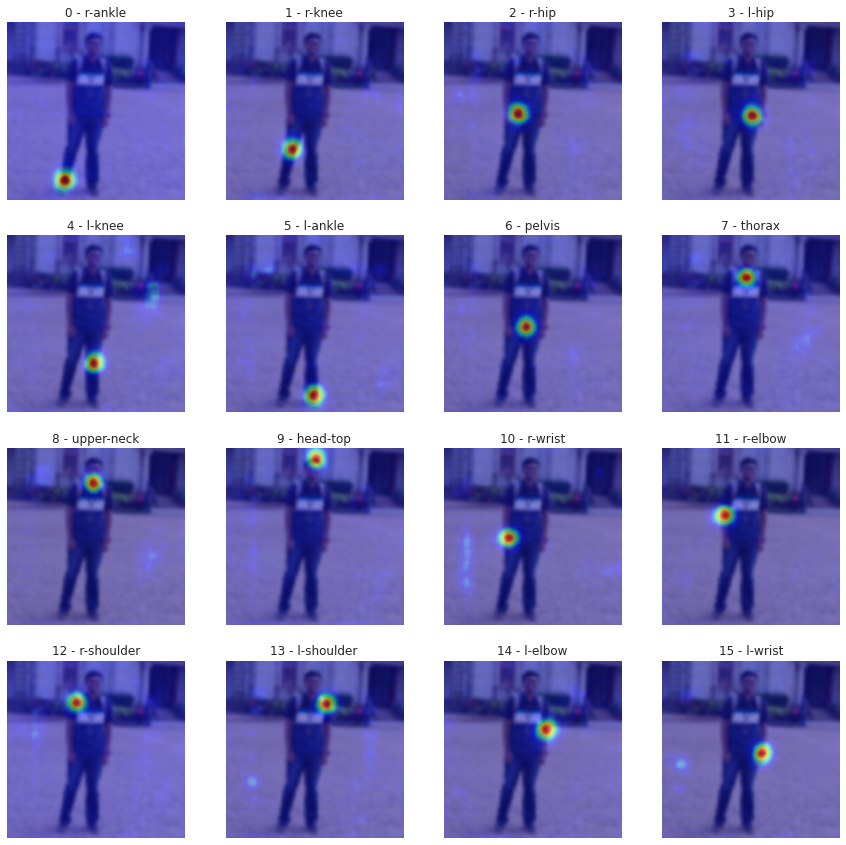

In [35]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

Here are the detections summarised in a single image

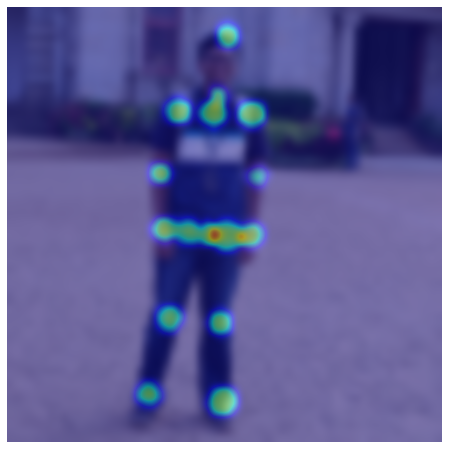

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

Now we will connect these detected regions

In [37]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

### Our final image with the estimated pose !

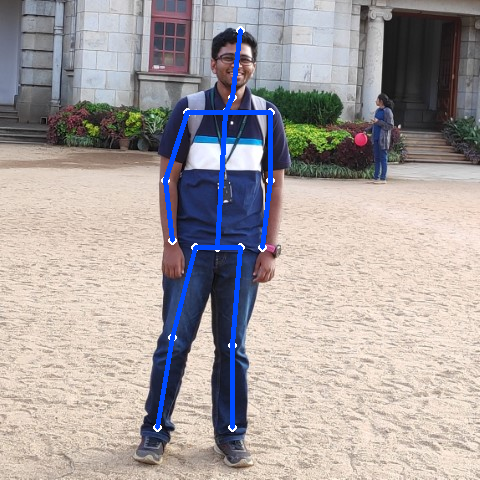

In [38]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

## Convert to ONNX and quantize the model

In [39]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

PyTorch Model Size

In [40]:
print_size_of_model(model)

Size (MB): 136.322013


In [41]:
new_model = copy.deepcopy(model)

Now we will Convert this model to ONNX

In [42]:
import io
import numpy as np
import torch.onnx

In [43]:
new_model.cuda()

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [44]:
# Input to the model
torch_model = new_model
torch_model.cuda()
batch_size = 1
#x = torch.randn(batch_size, 3, 256, 256, requires_grad=True).cuda()
# preprocessing stage ----------------------------------------------------------------------------------------------
x = preprocess_image(IMAGE_FILE).cuda()
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  # dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                  #               'output' : {0 : 'batch_size'}}
                  )

In [45]:
import onnx

onnx_model = onnx.load("simple_pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

Let's just check the size of the saved ONNX Model

In [46]:
print_size_of_onnx_model(onnx_model)

Size (MB): 135.910878


And also lets quicky test if the model works

In [48]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img[0].unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [49]:
to_numpy(tr_img.unsqueeze(0)).shape

(1, 1, 3, 256, 256)

In [50]:
ort_outs = np.array(ort_outs[0][0])

In [51]:
ort_outs

array([[[ 0.00699215,  0.00603252,  0.00356903, ...,  0.00233265,
          0.00631001,  0.0034187 ],
        [-0.0006397 ,  0.00184859, -0.00040879, ...,  0.00223629,
         -0.00170546,  0.0019334 ],
        [ 0.00066617,  0.00241927,  0.00113087, ...,  0.00319184,
          0.0014916 , -0.00119458],
        ...,
        [ 0.00079955,  0.00226496, -0.0004505 , ...,  0.00289437,
          0.00021339,  0.00121298],
        [ 0.00216139,  0.0020916 ,  0.00064254, ...,  0.00334238,
          0.00035155,  0.00366786],
        [-0.00022899,  0.00306709, -0.00268824, ...,  0.00159573,
         -0.00251968,  0.00324269]],

       [[ 0.00515583,  0.0031578 ,  0.00261917, ...,  0.00309882,
          0.00357619,  0.00640619],
        [ 0.00092244,  0.00431717, -0.00044787, ...,  0.00366029,
         -0.00014374,  0.00289988],
        [ 0.00572451,  0.00683463,  0.00336843, ...,  0.00451882,
          0.00240731,  0.00553672],
        ...,
        [ 0.00107685,  0.00398346, -0.00054733, ...,  

In [52]:
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

In [53]:
for pose_layer in ort_outs:
  print(pose_layer.shape)
  print(cv2.minMaxLoc(pose_layer))

(64, 64)
(-0.011161192320287228, 0.8895009160041809, (30, 61), (21, 57))
(64, 64)
(-0.004942239262163639, 0.9223843812942505, (31, 48), (23, 45))
(64, 64)
(-0.0016351137310266495, 0.8150326013565063, (31, 17), (26, 33))
(64, 64)
(-0.0036002041306346655, 0.9003095030784607, (23, 31), (32, 33))
(64, 64)
(-0.005151750519871712, 0.9342043995857239, (34, 58), (31, 46))
(64, 64)
(-0.005331711377948523, 0.9244154095649719, (18, 57), (31, 58))
(64, 64)
(-0.005365602672100067, 0.8714113831520081, (22, 33), (29, 33))
(64, 64)
(-0.006960644852370024, 0.9425212740898132, (28, 7), (30, 15))
(64, 64)
(-0.005819262936711311, 0.9222302436828613, (30, 19), (31, 12))
(64, 64)
(-0.007077989634126425, 0.9198341965675354, (33, 33), (32, 4))
(64, 64)
(-0.006865372881293297, 0.9894600510597229, (32, 35), (23, 32))
(64, 64)
(-0.0030953790992498398, 0.9256917834281921, (34, 29), (23, 24))
(64, 64)
(-0.0054887766018509865, 0.9150948524475098, (32, 12), (25, 14))
(64, 64)
(-0.005989647004753351, 0.91695952415466

In [54]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = ort_outs
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

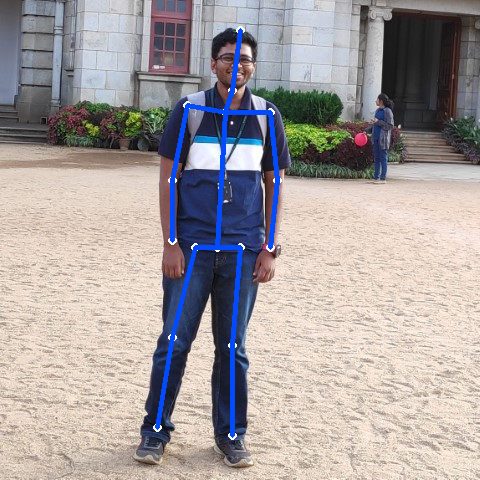

In [55]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

In [76]:
ort_outs = ort_outs[0][0]

In [77]:
len(ort_outs)

16

### ONNX Model Quantization

In [78]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

In [79]:
quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)

         Please use quantize_static for static quantization, quantize_dynamic for dynamic quantization.


In [80]:
onnx.save(quantized_model, 'simple_pose_estimation.quantized.onnx')

The Quantized Model is Half the Size ! (as expected but still yayyy !)

In [81]:
print_size_of_onnx_model(quantized_model)

Size (MB): 65.576468


Let's now test if the quantized model works

In [82]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [83]:
np.array(ort_outs).shape

(1, 1, 16, 64, 64)

In [84]:
ort_outs = np.array(ort_outs[0][0])

In [85]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = ort_outs
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

Pretty similar results !? eh ?

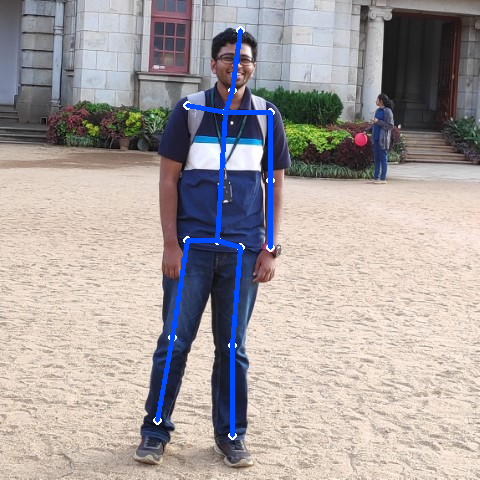

In [86]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))